In [1]:
# Importing Numpy, OpenCV and Matplotlib
import cv2  
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
#Importing python utilities
import math
from timeit import default_timer as timer
import pickle

In [3]:
#imports for interactive jupyter
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# 1. Basic stereo algorithm

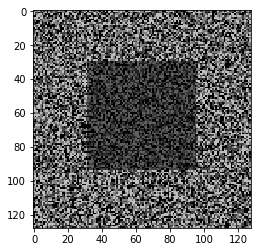

In [4]:
leftTest = cv2.imread('./Data/leftTest.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(leftTest, cmap='gray', vmin = 0, vmax = 255)

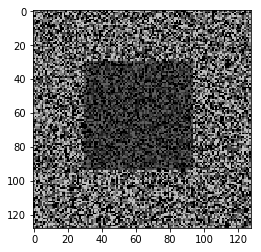

In [5]:
rightTest = cv2.imread('./Data/rightTest.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(rightTest, cmap='gray', vmin = 0, vmax = 255)

In [6]:
#Naive algorithm
#def ssd_template_image(template, image):
#    (tplRows, tplCols) = template.shape
#    s = np.zeros_like(image)
#    
#    for r in range(image.shape[0] - 1):
#        for c in range(image.shape[1] - 1):
#            for j in range(tplRows - 1):
#                for i in range(tplCols - 1):
#                    s[r,c] += (template[j, i] - image[r+j - tplRows/2, c + i - tplRows/2])**2
#    
#    return s

In [4]:
def normalize_255(matrix):
    return ((matrix.astype(np.float32) / np.max(matrix))*255).astype(np.uint8)

In [5]:
def disparity(image1, image2, LefttoRight = True, tplRows = 3, tplCols = 3, disparity_min = 0, disparity_max = 1000):
    if tplRows %2 == 0 or tplCols % 2 == 0:
        raise Exception('Use a symmetric template')
    disparity_max = min(disparity_max, image1.shape[1])
    row_margin = (tplRows - 1)/2 
    col_margin = (tplCols - 1)/2 
    ssd_map = np.zeros_like(image1)
    
    for row in np.arange(row_margin, image1.shape[0] - row_margin):
        for col in np.arange(col_margin, image1.shape[1] - col_margin):
            template = image1[row-row_margin:row+row_margin+1, col-col_margin:col+col_margin+1]
            template = template.astype(np.int32)
            image_bar = image2[row-row_margin:row+row_margin+1,:]
            image_bar = image_bar.astype(np.int32)
            if LefttoRight:
                match_values = np.arange(min(col + disparity_min, image2.shape[1]-col_margin-1), \
                                     min(col + disparity_max+1, image2.shape[1]-col_margin))
            else:
                match_values = np.arange(max(col - disparity_max, col_margin), \
                                         max(col - disparity_min+1, col_margin+1))

            SSDs = [((template - image_bar[:, m-col_margin:m+col_margin+1])**2).sum() for m in match_values]
            if not SSDs:
                continue
                
            ssd_map[row,col] = abs(match_values[np.argmin(SSDs)] - col)
            
    return ssd_map

In [9]:
ltr = disparity(rightTest, leftTest, LefttoRight = True, tplRows = 13, tplCols = 13)
rtl = disparity(leftTest, rightTest, LefttoRight = False, tplRows = 13, tplCols = 13)

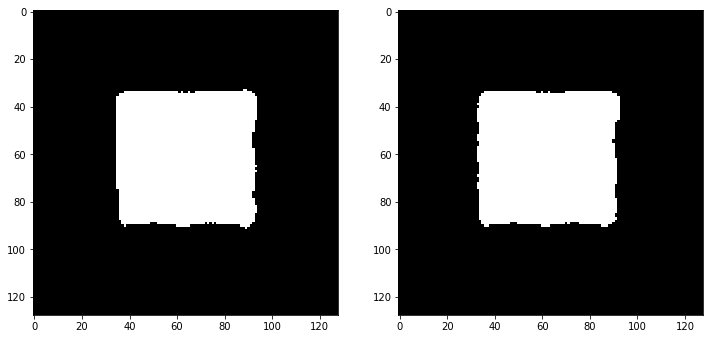

In [10]:
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(rtl), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(ltr), cmap='gray', vmin = 0, vmax = 255)

We can't get interesting results with templates of a size below 13. It is the absolute minimum to get expected white squares in the center of the disparity images, corresponding to a shift of a few pixels (since the bakground isn't shifted). Even so, we get some uncertainty with regards to the actual shape of the square (on the edges), so a better strategy could be to use bigger templates for matching (so that SSD is less sensitive by using more pixels to sum on).

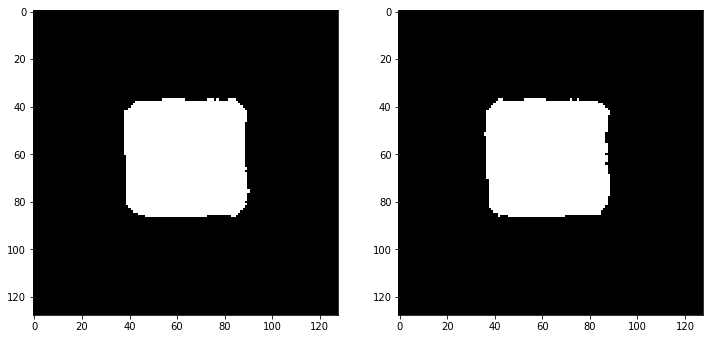

In [11]:
ltr = disparity(rightTest, leftTest, LefttoRight = True, tplRows = 25, tplCols = 25)
rtl = disparity(leftTest, rightTest, LefttoRight = False, tplRows = 25, tplCols = 25)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(rtl), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(ltr), cmap='gray', vmin = 0, vmax = 255)

In the end, it's a compromise: using templates with too low a size results in poor detection of the general figure's disparity (a few pixels on the edge only), but using windows too large for templates results in a smoothed version of the disparity image, where in this case, the borders of the inner square are considered to have a zero disparity.

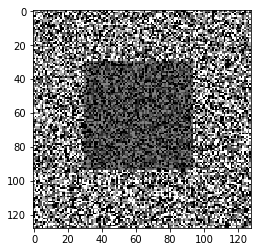

In [12]:
plt.imshow(normalize_255(ltr + rightTest), cmap='gray', vmin = 0, vmax = 255)

# 2. Real images

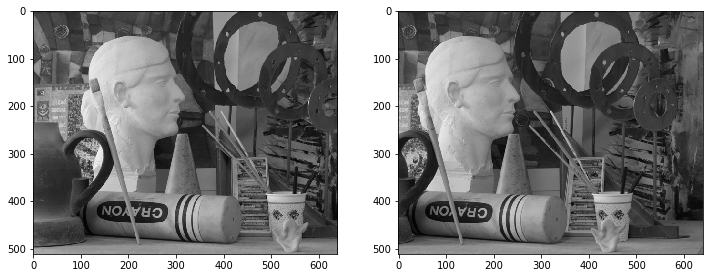

In [8]:
pair1L = cv2.imread('./Data/proj2-pair1-L.png', cv2.IMREAD_GRAYSCALE)
pair1R = cv2.imread('./Data/proj2-pair1-R.png', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(pair1L, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(pair1R, cmap='gray', vmin = 0, vmax = 255)

## 2.a. Disparity algorithm on real images

Sulpture in the foreground : at 526px on the left image, 429px on the right image => maximum disparity is expected to be less than 110.
Edge of the red painting in the background : 378px on the left image, 341px on the right image => minimum disparity expected to  be more than 35.

In [14]:
pair1ltr = disparity(pair1R, pair1L, LefttoRight = True, tplRows = 3, tplCols = 3, disparity_min = 35, disparity_max = 110)
pair1rtl = disparity(pair1L, pair1R, LefttoRight = False, tplRows = 3, tplCols = 3, disparity_min = 35, disparity_max = 110)

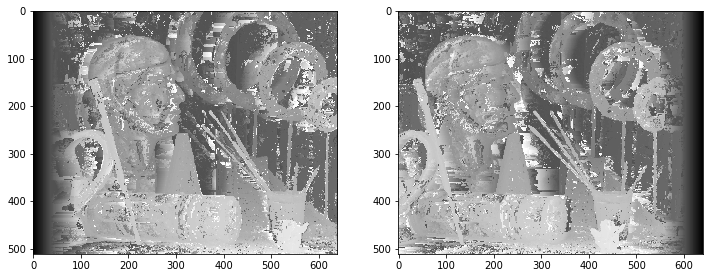

In [15]:
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(pair1rtl), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(pair1ltr), cmap='gray', vmin = 0, vmax = 255)

Meh, some noise

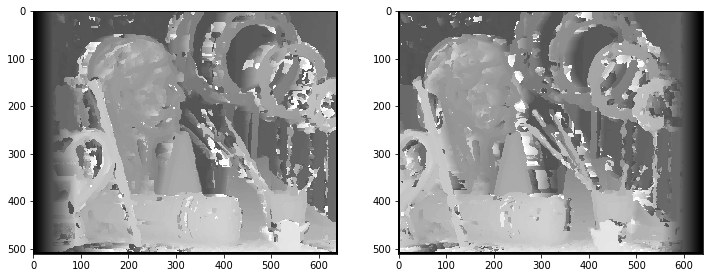

In [16]:
pair1ltr = disparity(pair1R, pair1L, LefttoRight = True, tplRows = 9, tplCols = 9, disparity_min = 35, disparity_max = 110)
pair1rtl = disparity(pair1L, pair1R, LefttoRight = False, tplRows = 9, tplCols = 9, disparity_min = 35, disparity_max = 110)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(pair1rtl), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(pair1ltr), cmap='gray', vmin = 0, vmax = 255)

Better

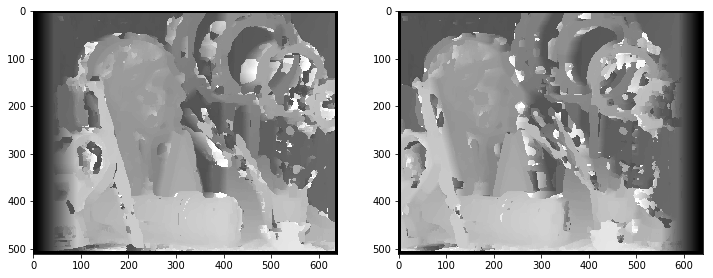

In [17]:
pair1ltr = disparity(pair1R, pair1L, LefttoRight = True, tplRows = 15, tplCols = 15, disparity_min = 35, disparity_max = 110)
pair1rtl = disparity(pair1L, pair1R, LefttoRight = False, tplRows = 15, tplCols = 15, disparity_min = 35, disparity_max = 110)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(pair1rtl), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(pair1ltr), cmap='gray', vmin = 0, vmax = 255)

Too much.

## 2.b. Ground truth comparison

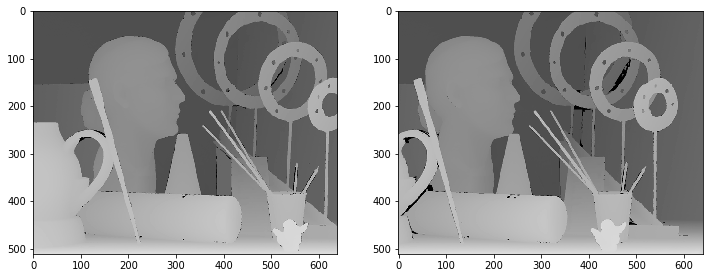

In [18]:
pair1_truth_L = cv2.imread('./Data/proj2-pair1-Disp-L.png', cv2.IMREAD_GRAYSCALE)
pair1_truth_R = cv2.imread('./Data/proj2-pair1-Disp-R.png', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(pair1_truth_L, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(pair1_truth_R, cmap='gray', vmin = 0, vmax = 255)

# 3. Influence of perturbations

## 3.a Influence of Gaussian noise

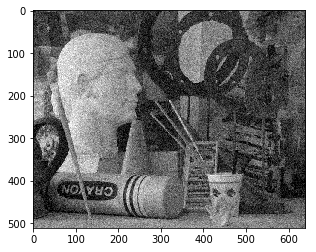

In [15]:
#Adding gaussian noise
sigma = 20

noise = np.zeros_like(pair1R)
noise = np.random.standard_normal(np.shape(pair1R)) * sigma
pair1RNoisy = pair1R + noise
pair1RNoisy[pair1RNoisy < 0] = 0
pair1RNoisy[pair1RNoisy > 255] = 255

plt.imshow(normalize_255(pair1RNoisy), cmap='gray', vmin = 0, vmax = 255)

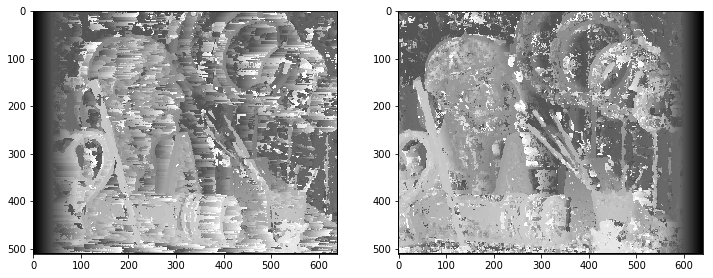

In [20]:
ltr_noise = disparity(pair1RNoisy, pair1L, LefttoRight = True, tplRows = 7, tplCols = 7, disparity_min = 35, disparity_max = 110)
rtl_noise = disparity(pair1L, pair1RNoisy, LefttoRight = False, tplRows = 7, tplCols = 7, disparity_min = 35, disparity_max = 110)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(rtl_noise), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(ltr_noise), cmap='gray', vmin = 0, vmax = 255)

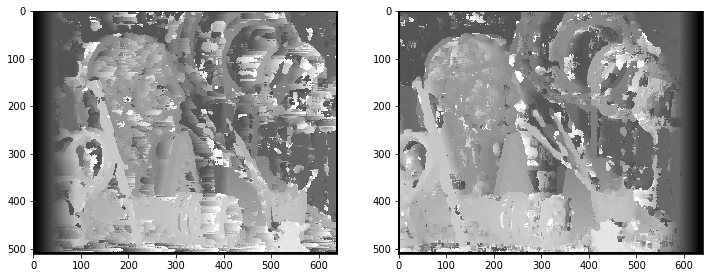

In [21]:
ltr_noise = disparity(pair1RNoisy, pair1L, LefttoRight = True, tplRows = 11, tplCols = 11, disparity_min = 35, disparity_max = 110)
rtl_noise = disparity(pair1L, pair1RNoisy, LefttoRight = False, tplRows = 11, tplCols = 11, disparity_min = 35, disparity_max = 110)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(rtl_noise), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(ltr_noise), cmap='gray', vmin = 0, vmax = 255)

## 3.b. Influence of contrast changes

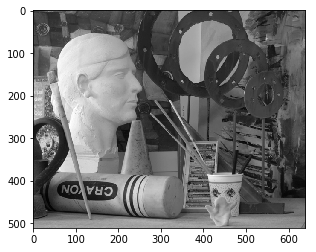

In [16]:
#Increasing contrast
pair1RContrast = pair1R * 1.1
pair1RContrast[pair1RContrast > 255] = 255

plt.imshow(normalize_255(pair1RContrast), cmap='gray', vmin = 0, vmax = 255)

In [ ]:
ltr_contrast = disparity(pair1RContrast, pair1L, LefttoRight = True, tplRows = 5, tplCols = 5, disparity_min = 35, disparity_max = 110)
rtl_contrast = disparity(pair1L, pair1RContrast, LefttoRight = False, tplRows = 5, tplCols = 5, disparity_min = 35, disparity_max = 110)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(rtl_contrast), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(ltr_contrast), cmap='gray', vmin = 0, vmax = 255)

In [ ]:
ltr_contrast = disparity(pair1RContrast, pair1L, LefttoRight = True, tplRows = 11, tplCols = 11, disparity_min = 35, disparity_max = 110)
rtl_contrast = disparity(pair1L, pair1RContrast, LefttoRight = False, tplRows = 11, tplCols = 11, disparity_min = 35, disparity_max = 110)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(rtl_contrast), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(ltr_contrast), cmap='gray', vmin = 0, vmax = 255)

# 4. Correlation

## 4.a. Correlation on the original images

In [6]:
def disparity_corr(image1, image2, LefttoRight = True, tplRows = 3, tplCols = 3, disparity_min = 0, disparity_max = 1000):
    if tplRows %2 == 0 or tplCols % 2 == 0:
        raise Exception('Use a symmetric template')
    disparity_max = min(disparity_max, image1.shape[1])
    row_margin = (tplRows - 1)/2 
    col_margin = (tplCols - 1)/2 
    corr_map = np.zeros_like(image1)
    
    for row in np.arange(row_margin, image1.shape[0] - row_margin):
        for col in np.arange(col_margin, image1.shape[1] - col_margin):
            template = image1[row-row_margin:row+row_margin+1, col-col_margin:col+col_margin+1]
            template = template.astype(np.float32)
            image_bar = image2[row-row_margin:row+row_margin+1,:]
            image_bar = image_bar.astype(np.float32)            
            if LefttoRight:
                match_values = np.arange(min(col + disparity_min, image2.shape[1]-col_margin-1), \
                                     min(col + disparity_max+1, image2.shape[1]-col_margin))
            else:
                match_values = np.arange(max(col - disparity_max, col_margin), \
                                         max(col - disparity_min+1, col_margin+1))

            corrs = [cv2.matchTemplate(image_bar[:, m-col_margin:m+col_margin+1], template, method = cv2.TM_CCOEFF_NORMED)[0,0] for m in match_values]
            if not corrs:
                continue

            corr_map[row,col] = abs(match_values[np.argmax(corrs)] - col)

    return corr_map

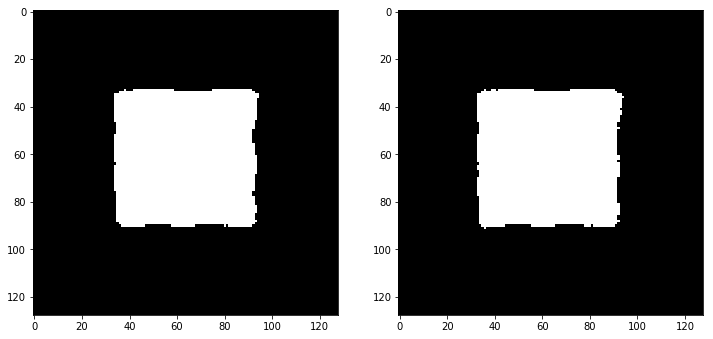

In [10]:
ltr_corr = disparity_corr(rightTest, leftTest, LefttoRight = True, tplRows = 11, tplCols = 11)
rtl_corr = disparity_corr(leftTest, rightTest, LefttoRight = False, tplRows = 11, tplCols = 11)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(rtl_corr), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(ltr_corr), cmap='gray', vmin = 0, vmax = 255)

Kowalski, Analysis. (Suggested pow3 for increasing disp values)

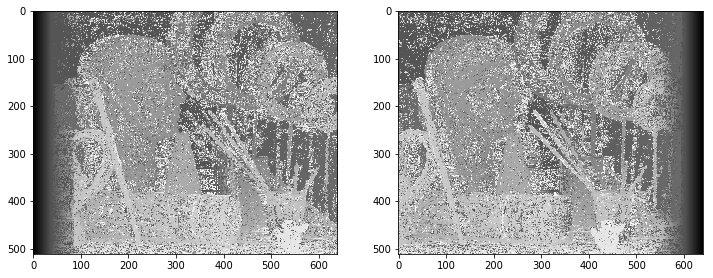

In [11]:
ltr_corr = disparity_corr(pair1R, pair1L, LefttoRight = True, tplRows = 3, tplCols = 3, disparity_min = 35, disparity_max = 110)
rtl_corr = disparity_corr(pair1L, pair1R, LefttoRight = False, tplRows = 3, tplCols = 3, disparity_min = 35, disparity_max = 110)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(rtl_corr), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(ltr_corr), cmap='gray', vmin = 0, vmax = 255)

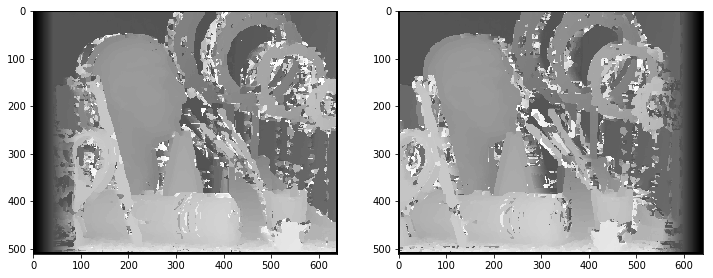

In [13]:
ltr_corr = disparity_corr(pair1R, pair1L, LefttoRight = True, tplRows = 11, tplCols = 11, disparity_min = 35, disparity_max = 110)
rtl_corr = disparity_corr(pair1L, pair1R, LefttoRight = False, tplRows = 11, tplCols = 11, disparity_min = 35, disparity_max = 110)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(rtl_corr), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(ltr_corr), cmap='gray', vmin = 0, vmax = 255)

## 4.b. Correlation on the altered images

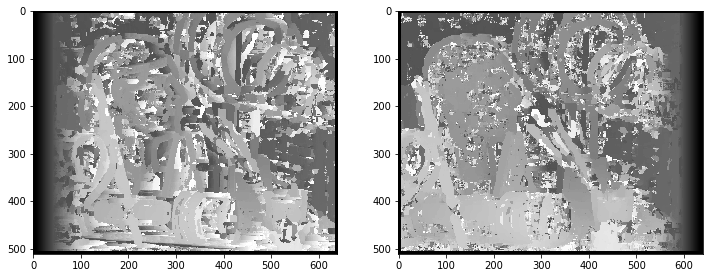

In [18]:
ltr_noise_corr = disparity_corr(pair1RNoisy, pair1L, LefttoRight = True, tplRows = 13, tplCols = 13, disparity_min = 35, disparity_max = 110)
rtl_noise_corr = disparity_corr(pair1L, pair1RNoisy, LefttoRight = False, tplRows = 13, tplCols = 13, disparity_min = 35, disparity_max = 110)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(rtl_noise_corr), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(ltr_noise_corr), cmap='gray', vmin = 0, vmax = 255)

In [ ]:
ltr_constrast_corr = disparity_corr(pair1RContrast, pair1L, LefttoRight = True, tplRows = 13, tplCols = 13, disparity_min = 35, disparity_max = 110)
rtl_constrast_corr = disparity_corr(pair1L, pair1RContrast, LefttoRight = False, tplRows = 13, tplCols = 13, disparity_min = 35, disparity_max = 110)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(rtl_constrast_corr), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(ltr_constrast_corr), cmap='gray', vmin = 0, vmax = 255)

# 5. 2nd pair

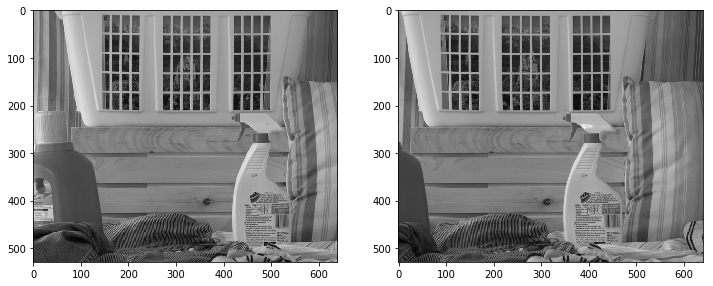

In [7]:
pair2L = cv2.imread('./Data/proj2-pair2-L.png', cv2.IMREAD_GRAYSCALE)
pair2R = cv2.imread('./Data/proj2-pair2-R.png', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(pair2L, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(pair2R, cmap='gray', vmin = 0, vmax = 255)

In [ ]:
pair2_truth_L = cv2.imread('./Data/proj2-pair2-Disp-L.png', cv2.IMREAD_GRAYSCALE)
pair2_truth_R = cv2.imread('./Data/proj2-pair2-Disp-R.png', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(pair2_truth_L, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(pair2_truth_R, cmap='gray', vmin = 0, vmax = 255)

In [ ]:
pair2ltr = disparity_corr(pair2R, pair2L, LefttoRight = True, tplRows = 51, tplCols = 51, disparity_min = 20, disparity_max = 120)
pair2rtl = disparity_corr(pair2L, pair2R, LefttoRight = False, tplRows = 51, tplCols = 51, disparity_min = 20, disparity_max = 120)

In [ ]:
plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.imshow(normalize_255(pair2rtl), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(1,2,2)
plt.imshow(normalize_255(pair2ltr), cmap='gray', vmin = 0, vmax = 255)

In [ ]:
#@interact(noise = (0,500), contrast = (0,100), template_size = (3,71,2), correlation = False, verbose = False)
def pair2(noise = 0, contrast = 0, correlation = False, template_size = 41, disparity_min = 20, disparity_max = 120, verbose = True):
    pair2L = cv2.imread('./Data/proj2-pair2-L.png', cv2.IMREAD_GRAYSCALE)
    pair2R = cv2.imread('./Data/proj2-pair2-R.png', cv2.IMREAD_GRAYSCALE)
    if verbose: 
        print("Original images")
        plt.figure(figsize=(12, 9))
        plt.subplot(1,2,1)
        plt.imshow(pair2L, cmap='gray', vmin = 0, vmax = 255)
        plt.subplot(1,2,2)
        plt.imshow(pair2R, cmap='gray', vmin = 0, vmax = 255)
        plt.show()

    noise = np.zeros_like(pair2R)
    noiseMat = np.random.standard_normal(np.shape(pair2R)) * noise
    pair2R = pair2R + noiseMat
    pair2R[pair2R < 0] = 0
    pair2R[pair2R > 255] = 255
    
    if verbose: 
        print("Images after applying noise")
        plt.figure(figsize=(12, 9))
        plt.subplot(1,2,1)
        plt.imshow(pair2L, cmap='gray', vmin = 0, vmax = 255)
        plt.subplot(1,2,2)
        plt.imshow(pair2R, cmap='gray', vmin = 0, vmax = 255)
        plt.show()

    pair2R = pair2R * (1 + contrast/100.)
    pair2R[pair2R > 255] = 255

    if verbose: 
        print("Images after applying contrast")
        plt.figure(figsize=(12, 9))
        plt.subplot(1,2,1)
        plt.imshow(pair2L, cmap='gray', vmin = 0, vmax = 255)
        plt.subplot(1,2,2)
        plt.imshow(pair2R, cmap='gray', vmin = 0, vmax = 255)
        plt.show()

    if not correlation:
        pair2ltr = disparity(pair2R, pair2L, LefttoRight = True, tplRows = template_size, tplCols = template_size, disparity_min = 20, disparity_max = 120)
        pair2rtl = disparity(pair2L, pair2R, LefttoRight = False, tplRows = template_size, tplCols = template_size, disparity_min = 20, disparity_max = 120)
    else:
        pair2ltr = disparity_corr(pair2R, pair2L, LefttoRight = True, tplRows = template_size, tplCols = template_size, disparity_min = 20, disparity_max = 120)
        pair2rtl = disparity_corr(pair2L, pair2R, LefttoRight = False, tplRows = template_size, tplCols = template_size, disparity_min = 20, disparity_max = 120)

    if verbose:
        print("Disparity with template of size " + str(template_size))
        
    plt.figure(figsize=(12, 9))
    plt.subplot(1,2,1)
    plt.imshow(normalize_255(pair2rtl), cmap='gray', vmin = 0, vmax = 255)
    plt.subplot(1,2,2)
    plt.imshow(normalize_255(pair2ltr), cmap='gray', vmin = 0, vmax = 255)

In [ ]:
plt.figure(figsize=(12, 9))
plt.subplot(2,2,1)
plt.imshow(pair2_truth_L, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,2)
plt.imshow(pair2_truth_R, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,3)
plt.imshow(cv2.imread('./Data/pair2/1-RtoL.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,4)
plt.imshow(cv2.imread('./Data/pair2/1-LtoR.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)

In [ ]:
plt.figure(figsize=(12, 9))
plt.subplot(2,2,1)
plt.imshow(pair2_truth_L, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,2)
plt.imshow(pair2_truth_R, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,3)
plt.imshow(cv2.imread('./Data/pair2/5-RtoL.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,4)
plt.imshow(cv2.imread('./Data/pair2/5-LtoR.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)

In [ ]:
plt.figure(figsize=(12, 9))
plt.subplot(2,2,1)
plt.imshow(pair2_truth_L, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,2)
plt.imshow(pair2_truth_R, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,3)
plt.imshow(cv2.imread('./Data/pair2/11-corr-RtoL.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,4)
plt.imshow(cv2.imread('./Data/pair2/11-corr-LtoR.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)

In [ ]:
plt.figure(figsize=(12, 9))
plt.subplot(2,2,1)
plt.imshow(pair2_truth_L, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,2)
plt.imshow(pair2_truth_R, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,3)
plt.imshow(cv2.imread('./Data/pair2/Noisy-7-RtoL.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,4)
plt.imshow(cv2.imread('./Data/pair2/Noisy-7-LtoR.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)

In [ ]:
plt.figure(figsize=(12, 9))
plt.subplot(2,2,1)
plt.imshow(pair2_truth_L, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,2)
plt.imshow(pair2_truth_R, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,3)
plt.imshow(cv2.imread('./Data/pair2/Noisy-17-RtoL.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,4)
plt.imshow(cv2.imread('./Data/pair2/Noisy-17-LtoR.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)

In [ ]:
plt.figure(figsize=(12, 9))
plt.subplot(2,2,1)
plt.imshow(pair2_truth_L, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,2)
plt.imshow(pair2_truth_R, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,3)
plt.imshow(cv2.imread('./Data/pair2/Noisy-13-corr-RtoL.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,4)
plt.imshow(cv2.imread('./Data/pair2/Noisy-13-corr-LtoR.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)

In [ ]:
plt.figure(figsize=(12, 9))
plt.subplot(2,2,1)
plt.imshow(pair2_truth_L, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,2)
plt.imshow(pair2_truth_R, cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,3)
plt.imshow(cv2.imread('./Data/pair2/Contrast-5-RtoL.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)
plt.subplot(2,2,4)
plt.imshow(cv2.imread('./Data/pair2/Contrast-5-LtoR.png', cv2.IMREAD_GRAYSCALE), cmap='gray', vmin = 0, vmax = 255)

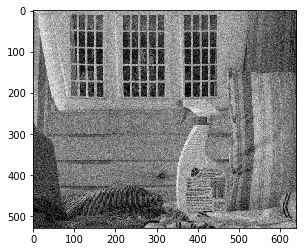

In [11]:
#Adding gaussian noise
sigma = 20

noise = np.zeros_like(pair2R)
noise = np.random.standard_normal(np.shape(pair2R)) * sigma
pair2RNoisy = pair2R + noise
pair2RNoisy[pair2RNoisy < 0] = 0
pair2RNoisy[pair2RNoisy > 255] = 255

plt.imshow(normalize_255(pair2RNoisy), cmap='gray', vmin = 0, vmax = 255)

for tplSize in np.arange(9,12,2):
    cv2.imwrite('./Data/pair2/Noisy-'+ str(tplSize) + '-corr-RtoL.png', \
        normalize_255(disparity_corr(pair2L, pair2RNoisy, LefttoRight = False, \
            tplRows = tplSize, tplCols = tplSize, disparity_min = 20, disparity_max = 120)))